In [11]:
import torch
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [13]:
class FF(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)

In [14]:
class VAE(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(dim1, dim2)
        self.fc21 = nn.Linear(dim2, dim3)  # Mean
        self.fc22 = nn.Linear(dim2, dim3)  # Variance
        self.fc3 = nn.Linear(dim3, dim2)
        self.fc4 = nn.Linear(dim2, dim1)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [15]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [16]:
def train(data_loader, model, optimizer, epochs=20):
    model.to(device)  # GPU
    model.train()
    losses = []
    for epoch in range(epochs):
        for i, (x, _) in enumerate(data_loader):
            x = x.to(device)  # GPU
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(x)
            loss = loss_function(recon_batch, x, mu, logvar)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss.item()}")
    return model, losses

In [17]:
def plot_latent(data_loader, model, num_batches=100):
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device)
            mu, logvar = model.encode(x.view(-1, 28*28))
            z = model.reparameterize(mu, logvar)
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, alpha=0.5)
            if i > num_batches:
                plt.colorbar()
                break

In [18]:
# Load MNIST dataset
transform_vae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x, start_dim=-2))
])

data_vae = datasets.MNIST('./data', transform=transform_vae, download=True)

data_loader_vae = torch.utils.data.DataLoader(data_vae, batch_size=128, shuffle=True)

# Initialize VAE model
vae_model = VAE(dim1=28*28, dim2=512, dim3=2)

# Initialize optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)

# Train VAE model
trained_model, losses = train(data_loader_vae, vae_model, optimizer)

0/0: 70487.109375
0/100: 23555.37109375
0/200: 22935.98046875
0/300: 21976.7734375
0/400: 22041.1484375
1/0: 21079.912109375
1/100: 20820.55078125
1/200: 21441.69921875
1/300: 19898.85546875
1/400: 22122.541015625
2/0: 21242.5703125
2/100: 20997.259765625
2/200: 21027.857421875
2/300: 20627.654296875
2/400: 20830.94140625
3/0: 20666.04296875
3/100: 20897.68359375
3/200: 20305.919921875
3/300: 20127.375
3/400: 20852.98828125
4/0: 20803.33203125
4/100: 20508.986328125
4/200: 21244.4296875
4/300: 20391.734375
4/400: 19539.94921875
5/0: 21020.943359375
5/100: 20196.224609375
5/200: 19870.48828125
5/300: 20549.869140625
5/400: 20058.61328125
6/0: 19741.796875
6/100: 20096.39453125
6/200: 20451.287109375
6/300: 20499.974609375
6/400: 19114.44921875
7/0: 19573.16796875
7/100: 19522.837890625
7/200: 19160.1328125
7/300: 20074.796875
7/400: 19423.609375
8/0: 19419.0859375
8/100: 20028.94921875
8/200: 20619.0078125
8/300: 20372.7109375
8/400: 19553.37890625
9/0: 19988.576171875
9/100: 19712.3535

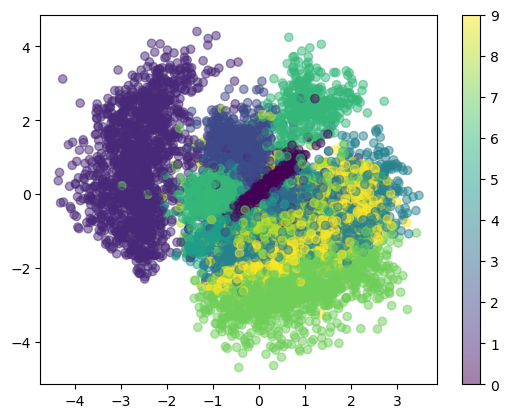

In [19]:
# Plot latent space
plot_latent(data_loader_vae, trained_model)
plt.show()

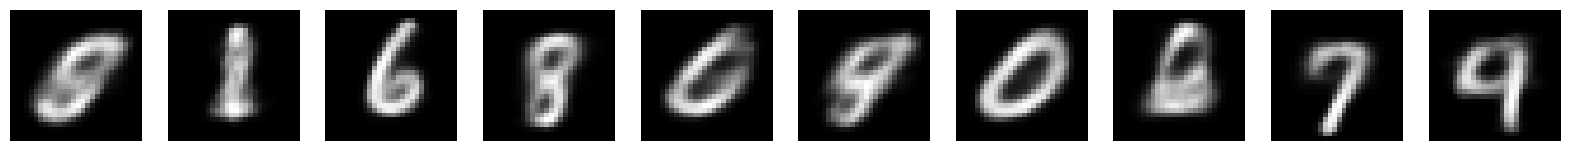

<Figure size 640x480 with 0 Axes>

In [20]:
def plot_generated_samples(model, num_samples=10):
    with torch.no_grad():
        z = torch.randn(num_samples, model.fc21.out_features).to(device)  # Sample from standard normal distribution
        generated_samples = model.decode(z).cpu().view(-1, 1, 28, 28)  # Pass through decoder
        generated_samples = generated_samples.numpy()

        fig, axs = plt.subplots(1, num_samples, figsize=(20, 2))
        for i, sample in enumerate(generated_samples):
            axs[i].imshow(sample[0], cmap='gray')
            axs[i].axis('off')
        plt.show()

# Plot generated samples
plot_generated_samples(trained_model)
plt.savefig('generated.pdf')